In [1]:
# -------- Preprocessing using SVD single --------
import cv2
import numpy as np
import os

def compute_svd(matrix, epsilon=1e-10):
    ata = np.dot(matrix.T, matrix)  # A^T * A
    eig_vals_v, eig_vecs_v = np.linalg.eig(ata)
    sorted_indices_v = np.argsort(-eig_vals_v)
    sigma = np.sqrt(np.maximum(eig_vals_v[sorted_indices_v], 0))
    sigma = np.where(sigma < epsilon, epsilon, sigma)  # Avoid divide by zero
    v = eig_vecs_v[:, sorted_indices_v]
    u = np.dot(matrix, v) / sigma  # Efficient U computation
    return u, sigma, v.T


def preprocess_with_svd_green_channel(image, target_size=(256, 256), dynamic_contrast=True):
    """
    Preprocess an image using SVD applied only on the green channel, and return both color and grayscale results.

    Args:
        image: Input RGB image as a NumPy array.
        target_size: Target resolution for processing.
        dynamic_contrast: Boolean to toggle dynamic contrast adjustments.

    Returns:
        processed_image: Color image with SVD applied to the green channel.
        grayscale_image: Grayscale image with the processed green channel.
    """
    # Resize the image
    image_resized = cv2.resize(image, target_size)

    # Extract the Green channel
    green_channel = image_resized[:, :, 1]

    # Convert green channel to float64 for precision during SVD
    green_channel_float = green_channel.astype(np.float64) / 255.0
    reshaped_green_channel = green_channel_float.reshape(-1, 1)

    # Apply SVD to the green channel
    U, S, Vt = compute_svd(reshaped_green_channel)

    # Use the first singular vector for reconstruction (more advanced techniques could use more components)
    reconstructed_green_channel = U[:, 0].reshape(target_size[1], target_size[0])

    # Normalize the reconstructed green channel
    normalized_green = (reconstructed_green_channel - np.min(reconstructed_green_channel)) / \
                       (np.max(reconstructed_green_channel) - np.min(reconstructed_green_channel))

    # Invert the image based on the mean intensity of the green channel
    if np.mean(normalized_green) > 0.5:
        inverted_green = 1.0 - normalized_green
    else:
        inverted_green = normalized_green

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the green channel
    clip_limit = 3.0 if dynamic_contrast else 2.0
    grid_size = (8, 8) if target_size[0] < 512 else (16, 16)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    enhanced_green = clahe.apply((inverted_green * 255).astype(np.uint8))

    # Normalize the enhanced green channel back to the range [0, 1]
    enhanced_green_normalized = enhanced_green / 255.0

    # Apply gamma correction for further tonal balance
    gamma = 1.2  # You can adjust this value based on the result
    gamma_corrected_green = np.power(enhanced_green_normalized, gamma)

    # Recombine the enhanced green channel with the original red and blue channels
    processed_image = image_resized.copy()
    processed_image[:, :, 1] = (gamma_corrected_green * 255).astype(np.uint8)

    # Convert the enhanced green channel to grayscale (using the processed green channel only)
    grayscale_image = (gamma_corrected_green * 255).astype(np.uint8)

    # Ensure the processed image is in uint8 format for saving
    processed_image = np.clip(processed_image, 0, 255).astype(np.uint8)
    grayscale_image = np.clip(grayscale_image, 0, 255).astype(np.uint8)

    return processed_image, grayscale_image  # Return both color and grayscale images



In [5]:
def process_images_svd_green(input_folder, output_folder, target_size=(256, 256)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_name in os.listdir(input_folder):
        input_path = os.path.join(input_folder, image_name)
        output_color_path = os.path.join(output_folder, f"color_{image_name}")
        output_grayscale_path = os.path.join(output_folder, f"grayscale_{image_name}")

        image = cv2.imread(input_path)
        if image is None:
            print(f"Failed to load {input_path}. Skipping.")
            continue

        # Apply SVD on the green channel only and get both processed color and grayscale images
        processed_color_image, processed_grayscale_image = preprocess_with_svd_green_channel(image, target_size)

        # Ensure processed images are in uint8 format before saving
        processed_color_image = np.clip(processed_color_image, 0, 255).astype(np.uint8)
        processed_grayscale_image = np.clip(processed_grayscale_image, 0, 255).astype(np.uint8)

        # Save the processed color image
        cv2.imwrite(output_color_path, processed_color_image)
        print(f"Processed and saved color image: {output_color_path}")

        # Save the processed grayscale image
        cv2.imwrite(output_grayscale_path, processed_grayscale_image)
        print(f"Processed and saved grayscale image: {output_grayscale_path}")


image_folder = r"data/training/images"   # Your input folder
output_folder = r"data/training/preprocessed_images"   # Your output folder

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Process all images in the folder
process_images_svd_green(image_folder, output_folder)

Processed and saved color image: data/training/preprocessed_images/color_29_training.tif
Processed and saved grayscale image: data/training/preprocessed_images/grayscale_29_training.tif
Processed and saved color image: data/training/preprocessed_images/color_28_training.tif
Processed and saved grayscale image: data/training/preprocessed_images/grayscale_28_training.tif
Processed and saved color image: data/training/preprocessed_images/color_22_training.tif
Processed and saved grayscale image: data/training/preprocessed_images/grayscale_22_training.tif
Processed and saved color image: data/training/preprocessed_images/color_25_training.tif
Processed and saved grayscale image: data/training/preprocessed_images/grayscale_25_training.tif
Processed and saved color image: data/training/preprocessed_images/color_30_training.tif
Processed and saved grayscale image: data/training/preprocessed_images/grayscale_30_training.tif
Processed and saved color image: data/training/preprocessed_images/col

In [7]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv
def unetmodel(input_shape, dropout=0.2, batchnorm=True):    
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers   
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
       
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)    
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()        
    return model

In [11]:
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
    IoU = []
    for label in labels:
        jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
        IoU.append(jaccard)     
    return np.mean(IoU)

In [13]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from skimage.io import imread
import numpy as np
from skimage.exposure import equalize_adapthist as clahe_equalized
np.random.seed(0) 


#CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized


path1 = r"data/training/preprocessed_images" #training images directory
path2 = r"data/training/manual"  #training masks directory

image_dataset = []
mask_dataset = [] 

patch_size = 512

images = sorted(os.listdir(path1)) 
for i, image_name in enumerate(images):  
    if image_name.endswith(".tif"):                   
        image = skimage.io.imread(path1+"/"+image_name)  #Read image
       #image = image[:,:,1] #selecting green channel
        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
#        image = Image.fromarray(image)        
#        image = image.resize((SIZE_X, SIZE_Y)) #resize image       
#        image = np.array(image) 
        SIZE_X = (image.shape[1] // patch_size) * patch_size
        SIZE_Y = (image.shape[0] // patch_size) * patch_size

       # Ensure that SIZE_X and SIZE_Y are at least the patch size to avoid invalid dimensions
        SIZE_X = max(SIZE_X, patch_size)
        SIZE_Y = max(SIZE_Y, patch_size)

        print(f"Resizing image to: SIZE_X={SIZE_X}, SIZE_Y={SIZE_Y}")

        if SIZE_X > 0 and SIZE_Y > 0:
            image = Image.fromarray(image)
            image = image.resize((SIZE_X, SIZE_Y))  # Resize image
            image = np.array(image)
        else:
            print(f"Skipping image due to invalid size: {image.shape}")
            continue
        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
            
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):                        
                single_patch_img = patches_img[i,j,:,:]                 
                single_patch_img = (single_patch_img.astype('float32')) / 255.                    
                image_dataset.append(single_patch_img)

masks = sorted(os.listdir(path2))  
for i, mask_name in enumerate(masks):  
    if mask_name.endswith(".tif"):                  
        mask = skimage.io.imread(path2+"/"+mask_name)   #Read masks
        SIZE_X = (mask.shape[1]//patch_size)*patch_size #getting size multiple of patch size
        SIZE_Y = (mask.shape[0]//patch_size)*patch_size #getting size multiple of patch size
        mask = Image.fromarray(mask)        
        mask = mask.resize((SIZE_X, SIZE_Y))  #resize image
        mask = np.array(mask)
        patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
            
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):                            
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask.astype('float32'))/255. 
                mask_dataset.append(single_patch_mask) 

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)


#importing models
# from model import unetmodel #residualunet, attentionunet, attention_residualunet
from tensorflow.keras.optimizers import Adam
# from evaluation_metrics import IoU_coef,IoU_loss

IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unetmodel(input_shape)
model.compile(optimizer = Adam(learning_rate = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
print("Image dataset shape:", image_dataset.shape)
print("Mask dataset shape:", mask_dataset.shape)


#splitting data into 70-30 ratio to validate training performance
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3, random_state=0)

#train model
history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 16,
                    validation_data=(x_test, y_test ), 
                    shuffle=False,
                    epochs=150)


#save model
model.save(r"s150.h5")

Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512
Resizing image to: SIZE_X=512, SIZE_Y=512


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512, 512,  │          0 │ activation_19[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 512, 512,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ activation_20[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256, 256,  │          0 │ activation_21[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ activation_22[0]

 Total params: 1,968,229 (7.51 MB)

 Trainable params: 1,965,283 (7.50 MB)

 Non-trainable params: 2,946 (11.51 KB)

Image dataset shape: (20, 512, 512, 1)
Mask dataset shape: (20, 512, 512, 1)
Epoch 1/150


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_79']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4598 - io_u_coef: 0.0775 - loss: -0.0775 - val_accuracy: 0.0516 - val_io_u_coef: 0.0897 - val_loss: -0.0897
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5220 - io_u_coef: 0.0923 - loss: -0.0923 - val_accuracy: 0.0477 - val_io_u_coef: 0.0869 - val_loss: -0.0869
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5531 - io_u_coef: 0.1042 - loss: -0.1042 - val_accuracy: 0.0501 - val_io_u_coef: 0.0884 - val_loss: -0.0884
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5592 - io_u_coef: 0.1162 - loss: -0.1162 - val_accuracy: 0.0648 - val_io_u_coef: 0.0898 - val_loss: -0.0898
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5733 - io_u_coef: 0.1253 - loss: -0.1253 - val_accuracy: 0.0771 - val_io_u_coef: 0.0887 - val_loss: -0.0887
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6152 - io_u_coef: 0.1325 - loss: -0.1325 - val_accuracy: 0.0982 - val_io_u_coef: 0.0877 - val_loss

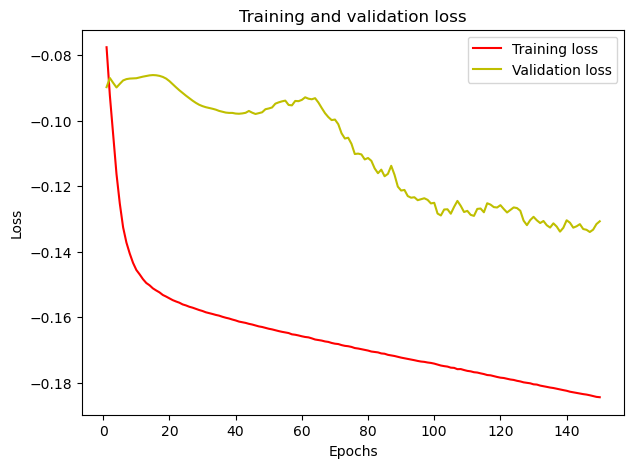

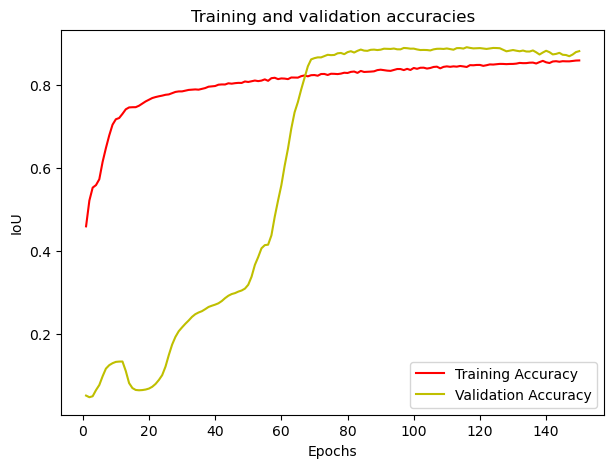

In [27]:
#training-validation loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#training-validation accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(7,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# #training-validation IoU curve
# iou_coef = history.history['IoU_coef']
# val_iou_coef = history.history['val_IoU_coef']
# plt.figure(figsize=(7,5))
# plt.plot(epochs, iou_coef, 'r', label='Training IoU')
# plt.plot(epochs, val_iou_coef, 'y', label='Validation IoU')
# plt.title('Training and validation IoU coefficients')
# plt.xlabel('Epochs')
# plt.ylabel('IoU')
# plt.legend()
# plt.show()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 512, 512,  │        160 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 512, 512,  │          0 │ activation_95[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 512, 512,  │      2,320 │ dropout_45[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 256, 256,  │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 256, 256,  │          0 │ activation_97[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 256, 256,  │      9,248 │ dropout_46[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 128, 128,  │          0 │ activation_98[0]

 Total params: 1,968,229 (7.51 MB)

 Trainable params: 1,965,283 (7.50 MB)

 Non-trainable params: 2,946 (11.51 KB)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_395']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Average accuracy is 0.9790002554617819
Mean IoU is 0.7712867734385226
Average Accuracy: 97.90%


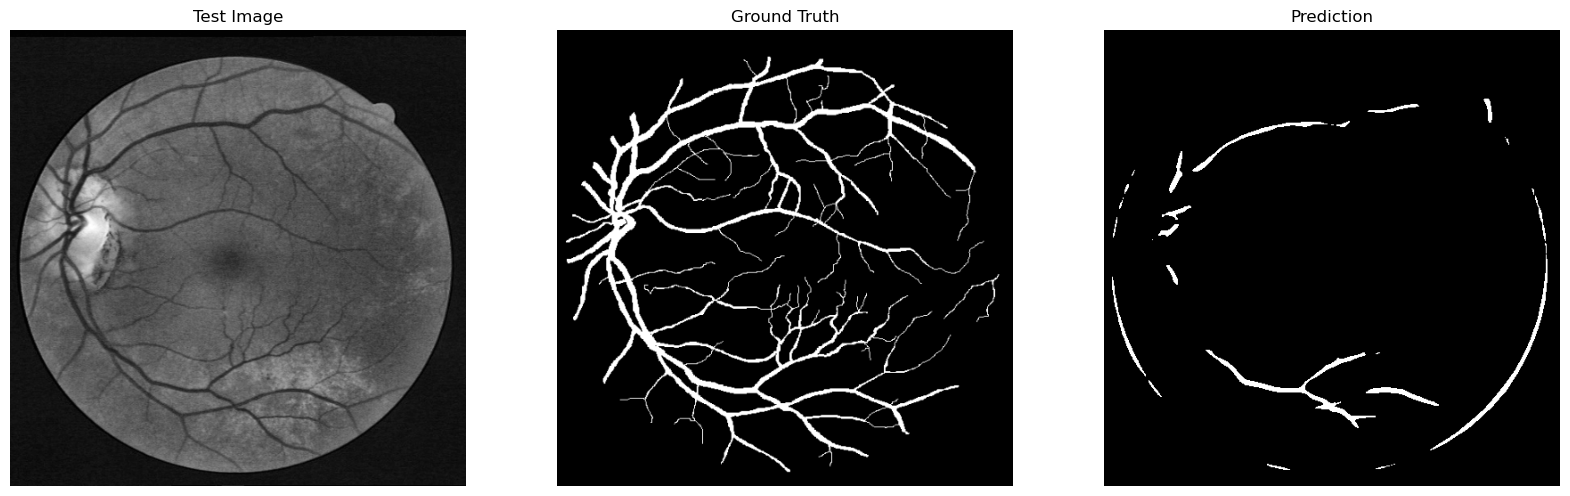

In [33]:
# -------- RANDOM IMAGE FROM TESTING SET _________

import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.optimizers import Adam
np.random.seed(0)

# CLAHE
def clahe_equalized(imgs,input_path):  
    if len(imgs.shape) > 2:  # If it's a color image (3 channels)
        # imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
        image = cv2.imread(input_path)
        if image is None:
            print(f"Failed to load {input_path}. Skipping.")
            return;

        # Apply SVD on the green channel only and get both processed color and grayscale images
        processed_color_image, processed_grayscale_image = preprocess_with_svd_green_channel(image, (256,256))

        # Ensure processed images are in uint8 format before saving
        processed_color_image = np.clip(processed_color_image, 0, 255).astype(np.uint8)
        processed_grayscale_image = np.clip(processed_grayscale_image, 0, 255).astype(np.uint8)
        imgs = processed_grayscale_image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

patch_size = 512

# Paths
path1 = r"data/training/images"   # Test dataset images directory path
#path2 = r"data/training/manual"  # Test dataset masks directory path

# Model loading and compilation
# from model import unetmodel  # Add other models if needed
# from tensorflow.keras.optimizers import Adam
# from evaluation_metrics import IoU_coef, IoU_loss

IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unetmodel(input_shape)  # Replace with other models if required
model.compile(optimizer=Adam(learning_rate=1e-3), loss=IoU_loss, metrics=['accuracy', IoU_coef])
model.load_weights(r"s150.h5")  # Loading weights

# Metrics
from sklearn.metrics import jaccard_score, confusion_matrix

testimg = []
ground_truth = []
prediction = []
global_IoU = []
global_accuracy = []

testimages = sorted(os.listdir(path1))
testmasks = sorted(os.listdir(path2))

for idx, image_name in enumerate(testimages):  
    if image_name.endswith(".tif"):  
        predicted_patches = []
        test_img = skimage.io.imread(os.path.join(path1, image_name))
        
        # Apply CLAHE to the green channel
        test = clahe_equalized(test_img[:, :, 1],"")
        
        # Resize to multiples of patch size
        SIZE_X = max((test_img.shape[1] // patch_size) * patch_size, patch_size)
        SIZE_Y = max((test_img.shape[0] // patch_size) * patch_size, patch_size)
        test = cv2.resize(test, (SIZE_X, SIZE_Y))
        testimg.append(test)
        test = np.array(test)

        # Patchify
        patches = patchify(test, (patch_size, patch_size), step=patch_size)

        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch = patches[i, j, :, :]
                single_patch_norm = (single_patch.astype('float32')) / 255.
                single_patch_norm = np.expand_dims(single_patch_norm, axis=-1)
                single_patch_input = np.expand_dims(single_patch_norm, 0)
                single_patch_prediction = (model.predict(single_patch_input)[0, :, :, 0] > 0.5).astype(np.uint8)
                predicted_patches.append(single_patch_prediction)
        
        # Reconstruct the image
        predicted_patches = np.array(predicted_patches)
        predicted_patches_reshaped = np.reshape(predicted_patches, 
                                                (patches.shape[0], patches.shape[1], patch_size, patch_size))
        reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape)
        prediction.append(reconstructed_image)

        # Process ground truth mask
        groundtruth = skimage.io.imread(os.path.join(path2, testmasks[idx]))
        groundtruth = cv2.resize(groundtruth, (SIZE_X, SIZE_Y))
        ground_truth.append(groundtruth)

        # Metrics calculation
        y_true = groundtruth.flatten()
        y_pred = reconstructed_image.flatten()
        
        labels = [0, 1]
        IoU = [jaccard_score(y_true, y_pred, pos_label=label, average='weighted') for label in labels]
        global_IoU.append(np.mean(IoU))

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        global_accuracy.append(accuracy)

# Overall metrics
avg_acc = np.mean(global_accuracy)
mean_IoU = np.mean(global_IoU)

print('Average accuracy is', avg_acc)
print('Mean IoU is', mean_IoU)

average_accuracy_percentage = avg_acc * 100
print(f"Average Accuracy: {average_accuracy_percentage:.2f}%")

# Visualization
import random
test_img_number = random.randint(0, len(testimg))
plt.figure(figsize=(20, 18))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(testimg[test_img_number], cmap='gray')
plt.axis('off')
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth[test_img_number], cmap='gray')
plt.axis('off')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction[test_img_number], cmap='gray')
plt.axis('off')
plt.show()



In [35]:
print('Average accuracy is', avg_acc)
print('Mean IoU is', mean_IoU)

average_accuracy_percentage = avg_acc * 100
print(f"Accuracy percentage: {average_accuracy_percentage:.2f}%")

Average accuracy is 0.9790002554617819
Mean IoU is 0.7712867734385226
Accuracy percentage: 97.90%


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 512, 512,  │        160 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_152[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_152      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 512, 512,  │          0 │ activation_152[0… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 512, 512,  │      2,320 │ dropout_72[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_153[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_153      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 256, 256,  │          0 │ activation_153[0… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 256, 256,  │      4,640 │ max_pooling2d_32… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_154[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_154      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 256, 256,  │          0 │ activation_154[0… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 256, 256,  │      9,248 │ dropout_73[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_155[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_155      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 128, 128,  │          0 │ activation_155[0

 Total params: 1,968,229 (7.51 MB)

 Trainable params: 1,965,283 (7.50 MB)

 Non-trainable params: 2,946 (11.51 KB)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_632']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Execution time: 0:00:00.392275


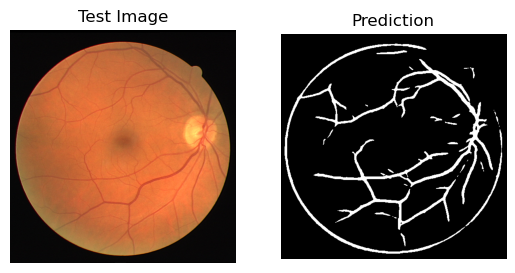

In [41]:
# ---------- PREDICTION ON SINGLE IMAGE ----------

import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.optimizers import Adam
np.random.seed(0)

# CLAHE
def clahe_equalized(imgs,input_path):  
    if len(imgs.shape) > 2:  # If it's a color image (3 channels)
        # imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
        image = cv2.imread(input_path)
        if image is None:
            print(f"Failed to load {input_path}. Skipping.")
            return;

        # Apply SVD on the green channel only and get both processed color and grayscale images
        processed_color_image, processed_grayscale_image = preprocess_with_svd_green_channel(image, (256,256))

        # Ensure processed images are in uint8 format before saving
        processed_color_image = np.clip(processed_color_image, 0, 255).astype(np.uint8)
        processed_grayscale_image = np.clip(processed_grayscale_image, 0, 255).astype(np.uint8)
        imgs = processed_grayscale_image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

patch_size = 512

IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unetmodel(input_shape)  # Replace with other models if required
model.compile(optimizer=Adam(learning_rate=1e-3), loss=IoU_loss, metrics=['accuracy', IoU_coef])
model.load_weights(r"s150.h5")  # Loading weights

from sklearn.metrics import jaccard_score, confusion_matrix

# Prediction on a single image
from datetime import datetime

reconstructed_image = []
# test_img = skimage.io.imread(r"data/training/preprocessed_images/grayscale_33_training.tif")
img_path = r"data/test/images/16_test.tif"
test_img = skimage.io.imread(img_path)
predicted_patches = []

start = datetime.now()

test = clahe_equalized(test_img,img_path)
SIZE_X = max((test_img.shape[1] // patch_size) * patch_size, patch_size)
SIZE_Y = max((test_img.shape[0] // patch_size) * patch_size, patch_size)
test = cv2.resize(test, (SIZE_X, SIZE_Y))
test = np.array(test)

patches = patchify(test, (patch_size, patch_size), step=patch_size)
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i, j, :, :]
        single_patch_norm = (single_patch.astype('float32')) / 255.
        single_patch_norm = np.expand_dims(single_patch_norm, axis=-1)
        single_patch_input = np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input)[0, :, :, 0] > 0.5).astype(np.uint8)
        predicted_patches.append(single_patch_prediction)

predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patch_size, patch_size))
reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape)

stop = datetime.now()
print('Execution time:', (stop - start))

plt.subplot(121)
plt.title('Test Image')
plt.imshow(test_img, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title('Prediction')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')
plt.show()